In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import matplotlib.pyplot as plt
import sys
from astropy import units as un
import os

os.environ[
    "CLMM_MODELING_BACKEND"
] = "ccl"  # here you may choose ccl, nc (NumCosmo) or ct (cluster_toolkit)

import clmm

from clmm import Cosmology
from clmm.support import mock_data as mock
from clmm.galaxycluster import GalaxyCluster
from clmm import dataops

# profile modelling package
import clmm.model_profile as mod

Make sure we know which version we're using

In [9]:
clmm.__version__

'0.16.0'

The modelling module can be used to create 2D lensing maps. This allows us to forward model systematics, starting at the map level. In this notebook, we use miscentering as an example systematic.

In [249]:
# specify parameters for NFW halo
c    = 3.5  #concentration
z_l  = 0.5  #lens redshift
z_s  = 1.0  #source redshift
Mass = 1e14 * un.M_sun

# define physical size of grid
r_min = 1e-3 * un.Mpc
r_max = 3    * un.Mpc

# number of pixels in grid
npix = 512

# define physcial size of a pixel
dx = r_max/npix

# define the center of the map (in Mpc)
center_1 = 0
center_2 = 0

# define radial and angular bins
N_r_bins   = 30
N_phi_bins = 25
r_bins   = np.insert(np.logspace(-2, np.log10(r_max.value), N_r_bins), 0, r_min.value) * r_max.unit
phi_bins = np.linspace(-np.pi, np.pi+0.01, num=N_phi_bins+1)

Now we can create the convergence maps

In [250]:
# set cosmology
cosmo = Cosmology(H0=70.0, Omega_dm0=0.25, Omega_b0=0.05, Omega_k0=0.0)

# lensing_map has the option to return either Sigma map or the convergence map
lensing_map = mod.profiles(cosmo,mdelta=Mass,cdelta=c,z_l=z_l,z_s=z_s,
                           halo_profile_model='nfw',delta_mdef=200,
                           massdef='critical',compute_sigma=False)

# make map
kappa_map = lensing_map.kappa_or_profile_2D(npix,r_max) 

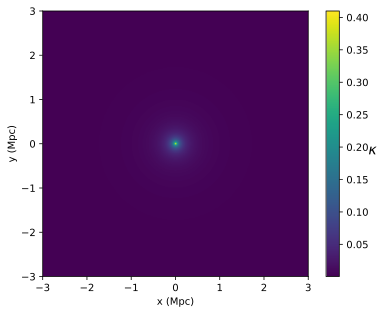

In [265]:
axlim = r_max.value
plt.imshow(kappa_map,extent=[-axlim,axlim,-axlim,axlim],origin='lower')
plt.xlabel('x ({0})'.format(r_max.unit))
plt.ylabel('y ({0})'.format(r_max.unit))
plt.colorbar().set_label('$\\kappa$',rotation=0,fontsize=14)
plt.show()

Repeat the procedure for a Sigma map

In [252]:
# lensing_map has the option to return either Sigma map or the convergence map.
lensing_map = mod.profiles(cosmo,mdelta=Mass,cdelta=c,z_l=z_l,z_s=z_s,
                           halo_profile_model='nfw',delta_mdef=200,
                           massdef='critical',compute_sigma=True)

# make map
Sigma_map = lensing_map.kappa_or_profile_2D(npix,r_max)

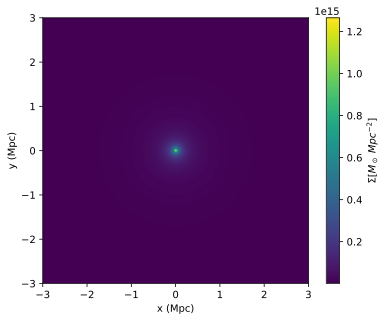

In [253]:
axlim = r_max.value
plt.imshow(Sigma_map,extent=[-axlim,axlim,-axlim,axlim],origin='lower')
plt.xlabel('x ({0})'.format(r_max.unit))
plt.ylabel('y ({0})'.format(r_max.unit))
plt.colorbar().set_label('$\\Sigma [M_\odot\; Mpc^{-2}]$',rotation=90)
plt.show()

We can transform from the convergence to the shear with the Kaiser Squires algorithm, returning the e1 and e2 shear maps.

In [254]:
e1_map, e2_map = mod.KaiserSquires(kappa_map)

/Users/alessandrafumagalli/DESC/CLMM/clmm/model_profile.py:230: RuntimeWarning: divide by zero encountered in divide
  ---------
/Users/alessandrafumagalli/DESC/CLMM/clmm/model_profile.py:230: RuntimeWarning: invalid value encountered in multiply
  ---------
/Users/alessandrafumagalli/DESC/CLMM/clmm/model_profile.py:231: RuntimeWarning: divide by zero encountered in divide
  et,ex: arrays
/Users/alessandrafumagalli/DESC/CLMM/clmm/model_profile.py:231: RuntimeWarning: invalid value encountered in multiply
  et,ex: arrays


Plot the e1 and e2 maps

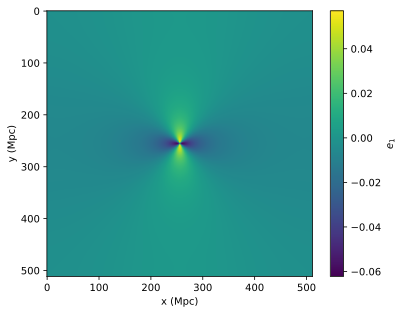

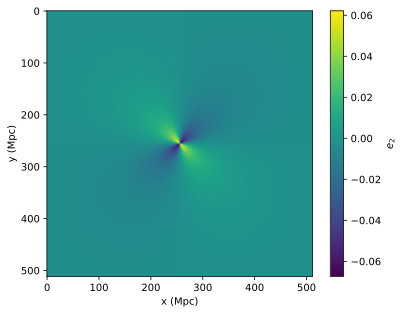

In [255]:
plt.imshow(e1_map)
plt.xlabel('x ({0})'.format(r_max.unit))
plt.ylabel('y ({0})'.format(r_max.unit))
plt.colorbar().set_label('$e_1$',rotation=90)
plt.show()

plt.imshow(e2_map)
plt.xlabel('x ({0})'.format(r_max.unit))
plt.ylabel('y ({0})'.format(r_max.unit))
plt.colorbar().set_label('$e_2$',rotation=90)
plt.show()

from the convergence map we can compute the convergence profile, and from the e1 and e2 maps we can compute the tangential shear profile.

The getTangential function uses the e1 and e2 maps as an input, along with a map center, and returns e_tangential and e_cross maps about a given center. 

The function also returns a radius map and an angle map, which is used when computing radial profile with getRadial

In [256]:
et_map, ex_map, radius_map, angle_map = mod.get_Tangential_and_Cross(e1_map, e2_map, [center_1, center_2], dx=dx.value)

/Users/alessandrafumagalli/DESC/CLMM/clmm/model_profile.py:273: RuntimeWarning: invalid value encountered in divide
  tangential shear map


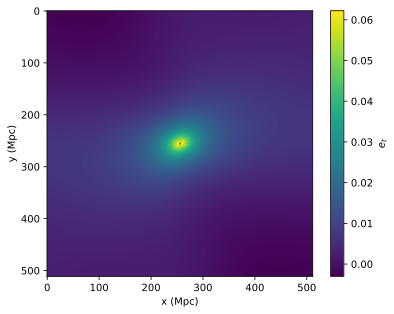

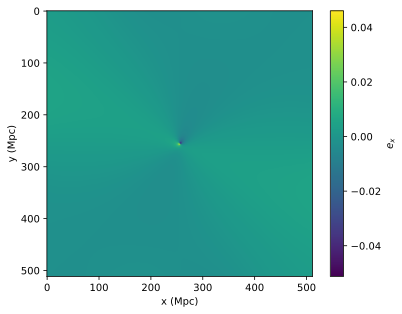

In [257]:
plt.imshow(et_map)
plt.xlabel('x ({0})'.format(r_max.unit))
plt.ylabel('y ({0})'.format(r_max.unit))
plt.colorbar().set_label('$e_t$',rotation=90)
plt.show()

plt.imshow(ex_map)
plt.xlabel('x ({0})'.format(r_max.unit))
plt.ylabel('y ({0})'.format(r_max.unit))
plt.colorbar().set_label('$e_x$',rotation=90)
plt.show()

With the radius_map and angle_map, we can calculate the radial convergence profile from the kappa map and the radial tangential shear profile from the e_tangential map, using the getRadial function

In [258]:
kappa_radial, gammat_radial = mod.get_Radial(radius_map,angle_map,
                                            r_bins.value,phi_bins,
                                            kappa_map,et_map)

/Users/alessandrafumagalli/DESC/CLMM/clmm/model_profile.py:324: RuntimeWarning: invalid value encountered in divide
/Users/alessandrafumagalli/DESC/CLMM/clmm/model_profile.py:325: RuntimeWarning: invalid value encountered in divide


plot the radial convergence and tangential shear profiles. Note that these profiles are not averaged over all angles yet, meaning that these profiles are 2D (radial and angular). This is useful for miscentering which leaves anisotropic signatures on the resulting lensing profiles

Text(0.5, 1.0, '$\\gamma_t$')

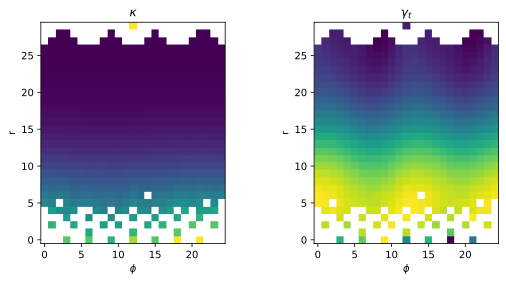

In [259]:
fig,ax = plt.subplots(1,2,figsize=(9,4))

ax[0].imshow(kappa_radial,origin='lower')
ax[1].imshow(gammat_radial,origin='lower')

ax[0].set_ylabel('r')
ax[0].set_xlabel('$\phi$')

ax[1].set_ylabel('r')
ax[1].set_xlabel('$\phi$')

ax[0].set_title(r'$\kappa$')
ax[1].set_title(r'$\gamma_t$')

We can recover the 1D radial convergence and tangential shear profiles as follows

In [260]:
kappa_1D_radial  = kappa_radial.mean(axis=-1)
gammat_1D_radial = gammat_radial.mean(axis=-1)

Plot the 1D radial profiles

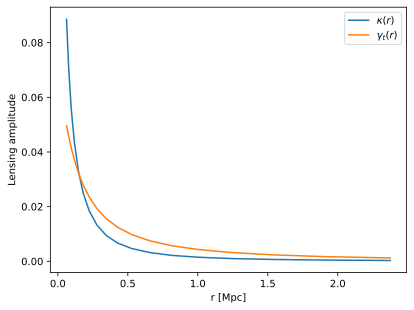

In [240]:
r_bins_mid = 0.5 * (r_bins[1:] + r_bins[:-1])
plt.plot(r_bins_mid,kappa_1D_radial,label='$\\kappa(r)$')
plt.plot(r_bins_mid,gammat_1D_radial,label='$\gamma_t(r)$')
plt.legend()
plt.xlabel('r [Mpc]')
plt.ylabel('Lensing amplitude')
plt.show()

## Miscentering

We now repeat the above procedure, but this time we use an incorrect center (relative to the true hale center) when performing the calculations, the exemplify the impact of miscentering

In [241]:
# First we define a miscentring parameter
R_mis = 0.05 # Mpc

# find new center based on R_mis
_phi_Rmis = 2*np.pi*np.random.random()  # isotropic angle for mis-centering

# mis-centered coordinates
center_1 = R_mis*np.cos(_phi_Rmis)
center_2 = R_mis*np.sin(_phi_Rmis)

# get tangential and radial profiles
et_map, ex_map, radius_map, angle_map = mod.get_Tangential_and_Cross(e1_map, e2_map, [center_1, center_2], dx=dx.value)
kappa_radial, gammat_radial = mod.get_Radial(radius_map,angle_map,
                                            r_bins.value,phi_bins,
                                            kappa_map,et_map)

/Users/alessandrafumagalli/DESC/CLMM/clmm/model_profile.py:324: RuntimeWarning: invalid value encountered in divide
/Users/alessandrafumagalli/DESC/CLMM/clmm/model_profile.py:325: RuntimeWarning: invalid value encountered in divide


In [305]:
def plot_maps_and_profiles(kappa_map,Sigma_map,e1_map,e2_map,et_map,ex_map,
                       kappa_radial,gammat_radial,r_bins):
    '''quickly plot the convergence, e1,e2, ex,et and radial profiles
    '''
    fig, ax1 = plt.subplots(3,2,figsize=(10,18))
    ax = ax1.flatten()

    plt.sca(ax[0])
    plt.imshow(kappa_map,origin = 'lower')
    plt.xlabel('x ({0})'.format(r_max.unit))
    plt.ylabel('y ({0})'.format(r_max.unit))
    plt.colorbar()
    plt.title(r'$\kappa$')

    plt.sca(ax[1])
    plt.imshow(Sigma_map,origin = 'lower')
    plt.xlabel('x ({0})'.format(r_max.unit))
    plt.ylabel('y ({0})'.format(r_max.unit))
    plt.colorbar()
    plt.title(r'$\Sigma [M_\odot\; Mpc^{-2}]$')


    plt.sca(ax[2])
    plt.imshow(e1_map)
    plt.xlabel('x ({0})'.format(r_max.unit))
    plt.ylabel('y ({0})'.format(r_max.unit))
    plt.colorbar()
    plt.title('$e_1$')
    
    plt.sca(ax[3])
    plt.imshow(e2_map)
    plt.xlabel('x ({0})'.format(r_max.unit))
    plt.ylabel('y ({0})'.format(r_max.unit))
    plt.colorbar()
    plt.title('$e_2$')
    
    
    plt.sca(ax[4])
    plt.imshow(et_map)
    plt.xlabel('x ({0})'.format(r_max.unit))
    plt.ylabel('y ({0})'.format(r_max.unit))
    plt.colorbar()
    plt.title('$e_t$')
    
    plt.sca(ax[5])
    plt.imshow(ex_map)
    plt.xlabel('x ({0})'.format(r_max.unit))
    plt.ylabel('y ({0})'.format(r_max.unit))
    plt.colorbar()
    plt.title('$e_x$')

    plt.subplots_adjust(bottom=0.3)
    plt.show()


    r_bins_mid = 0.5 * (r_bins[1:] + r_bins[:-1])

    fig,ax = plt.subplots(1,2,figsize=(10,4))
    
    ax[0].imshow(kappa_radial,origin='lower')
    ax[1].imshow(gammat_radial,origin='lower')
    
    ax[0].set_ylabel('r')
    ax[0].set_xlabel('$\phi$')
    
    ax[1].set_ylabel('r')
    ax[1].set_xlabel('$\phi$')
    
    ax[0].set_title(r'$\kappa$')
    ax[1].set_title(r'$\gamma_t$')    
    plt.show()


    plt.figure()
    r_bins_mid = 0.5 * (r_bins[1:] + r_bins[:-1])
    plt.plot(r_bins_mid,kappa_1D_radial,label='$\\kappa(r)$')
    plt.plot(r_bins_mid,gammat_1D_radial,label='$\gamma_t(r)$')
    plt.legend()
    plt.xlabel('r [Mpc]')
    plt.ylabel('Lensing amplitude')

    plt.show()

we can plot all of the results at once using the plot_maps_and_profiles function

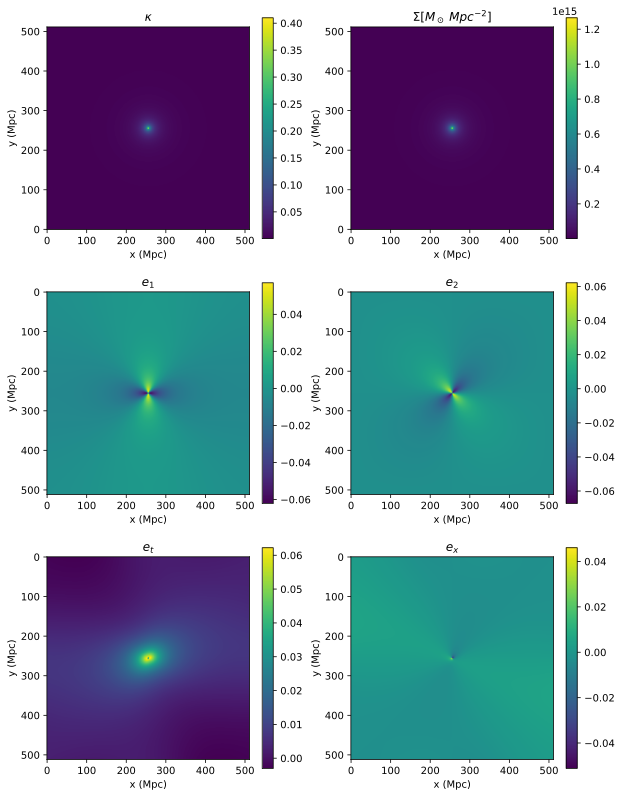

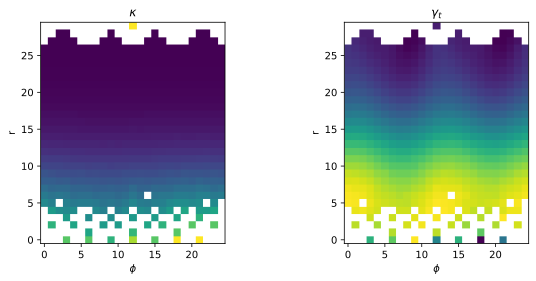

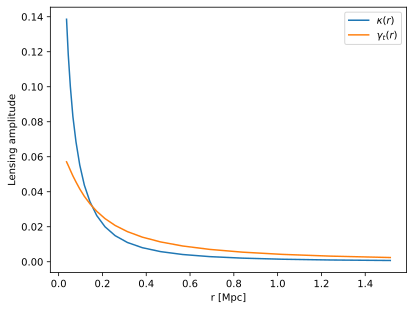

In [306]:
plot_maps_and_profiles(kappa_map,Sigma_map,e1_map,e2_map,et_map,ex_map,
                       kappa_radial,gammat_radial,r_bins) 

We can also investigate how the 1D radial lensing profiles change as a function of miscentering

Now define a miscentering distribution

In [244]:
# define miscentring distribution
R_mis_max = 0.5
N_R_mis   = 15
R_mis_arr = np.insert(np.logspace(-2, np.log10(R_mis_max), N_R_mis-1), 0, 0)

In [245]:
et_map = np.zeros((N_R_mis,kappa_map.shape[0],kappa_map.shape[1]))
ex_map = np.zeros(et_map.shape)
radius_map = np.zeros(et_map.shape)
angle_map  = np.zeros(et_map.shape)

kappa_radial  = np.zeros((N_R_mis,N_r_bins,N_phi_bins))
gammat_radial = np.zeros(kappa_radial.shape)

for j in range(len(R_mis_arr)):

    _phi_Rmis = 2*np.pi*np.random.random()  # isotropic angle for mis-centering

    # mis-centered coordinates
    center_1 = R_mis_arr[j]*np.cos(_phi_Rmis)
    center_2 = R_mis_arr[j]*np.sin(_phi_Rmis)

    et_map[j], ex_map[j], radius_map[j], angle_map[j] = mod.get_Tangential_and_Cross(e1_map, e2_map, [center_1, center_2], dx=dx.value)

    kappa_radial[j], gammat_radial[j] = mod.get_Radial(radius_map[j],angle_map[j],
                                                      r_bins.value,phi_bins,
                                                      kappa_map,et_map[j])

/Users/alessandrafumagalli/DESC/CLMM/clmm/model_profile.py:273: RuntimeWarning: invalid value encountered in divide
  tangential shear map
/Users/alessandrafumagalli/DESC/CLMM/clmm/model_profile.py:324: RuntimeWarning: invalid value encountered in divide
/Users/alessandrafumagalli/DESC/CLMM/clmm/model_profile.py:325: RuntimeWarning: invalid value encountered in divide
/Users/alessandrafumagalli/DESC/CLMM/clmm/model_profile.py:324: RuntimeWarning: invalid value encountered in divide
/Users/alessandrafumagalli/DESC/CLMM/clmm/model_profile.py:325: RuntimeWarning: invalid value encountered in divide
/Users/alessandrafumagalli/DESC/CLMM/clmm/model_profile.py:324: RuntimeWarning: invalid value encountered in divide
/Users/alessandrafumagalli/DESC/CLMM/clmm/model_profile.py:325: RuntimeWarning: invalid value encountered in divide
/Users/alessandrafumagalli/DESC/CLMM/clmm/model_profile.py:324: RuntimeWarning: invalid value encountered in divide
/Users/alessandrafumagalli/DESC/CLMM/clmm/model_p

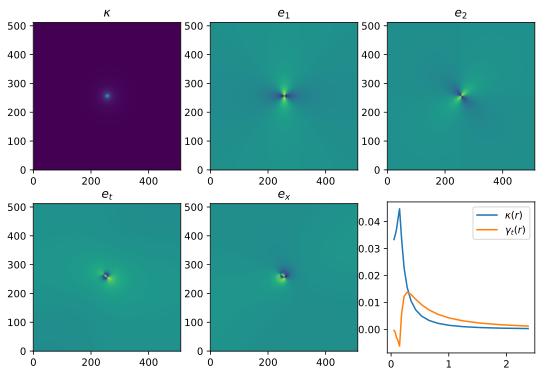

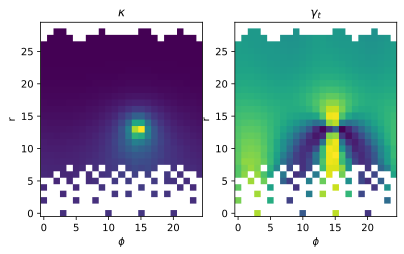

In [246]:
R_mis_ind = 10
plot_maps_and_profiles(kappa_map,e1_map,e2_map,et_map[R_mis_ind],ex_map[R_mis_ind],
                       kappa_radial[R_mis_ind],gammat_radial[R_mis_ind],r_bins)

Finally we can plot the lensing profiles for the whole miscentering distrubtion

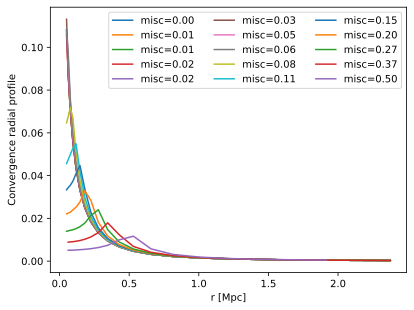

In [247]:
for i in range(N_R_mis):
    plt.plot(r_bins_mid,kappa_radial[i].mean(axis=-1),label='misc=%1.2f' %R_mis_arr[i])
plt.xlabel('r [Mpc]')
plt.ylabel('Convergence radial profile')
plt.legend(ncol=3)
plt.show()

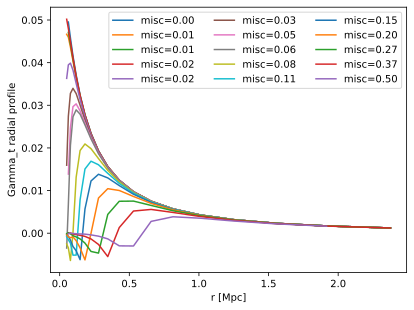

In [248]:
for i in range(N_R_mis):
    plt.plot(r_bins_mid,gammat_radial[i].mean(axis=-1),label='misc=%1.2f' %R_mis_arr[i])
plt.xlabel('r [Mpc]')
plt.ylabel('Gamma_t radial profile')
plt.legend(ncol=3)
plt.show()